<a href="https://colab.research.google.com/github/SergiGR28/Treball-final-docking/blob/main/Treball_final_docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Treball final de docking molecular de la proteina Mpro del SARS-CoV-2 amb el lligand N3R
#Sergi Grau
#Simulació de sistemes nanometrics

In [2]:
#1a part cerca de lligands específics per a la proteïna
# Importa els components de rcsbsearchapi necessaris per a aquesta cerca
%pip install rcsbsearchapi
from rcsbsearchapi import rcsb_attributes as attrs

/tmp/ipython-input-2-345898070.py:4: DeprecationWarning: Please migrate to the use of our new and improved package, rcsb-api (https://rcsbapi.readthedocs.io/en/latest/),
    which contains all the same functionalities as rcsbsearchapi and more! New features will only be added to the new rcsb-api package.
    For more details, see https://github.com/rcsb/py-rcsbsearchapi/issues/51.
  from rcsbsearchapi import rcsb_attributes as attrs


In [3]:
# La consulta tindrà tres components, que s'etiquetaran q1, q2 i q3.
ECnumber = "3.4.22.69"

q1 = attrs.rcsb_polymer_entity.rcsb_ec_lineage.id == ECnumber    # buscant estructures de Mpro amb EC = 3.4.22.69
q2 = attrs.chem_comp.formula_weight >= 300                       # establir el límit inferior del pes molecular
q3 = attrs.chem_comp.formula_weight <= 800                       # establir el límit superior del pes molecular

query = q1 & q2 & q3              # combinant les tres consultes en una de sola

resultL = list(query())          # assigna els resultats de la consulta a una variable de llista

print(resultL[0:10])              # llista els 10 primers resultats

print("There are", len(resultL), " structures that contain ligands in the RCSB PDB.")

['2YNB', '3ATW', '3AVZ', '3AW0', '3TIT', '3TIU', '3TNS', '3TNT', '3V3M', '4OVZ']
There are 1128  structures that contain ligands in the RCSB PDB.


In [4]:
molResultL = list(query("mol_definition"))
print("There are",len(molResultL), "ligands for EC Number", ECnumber, "in this list. Here is a list of the first 10 ligands.")
molResultL[0:10]

There are 896 ligands for EC Number 3.4.22.69 in this list. Here is a list of the first 10 ligands.


['06I', '06Q', '0AX', '0BO', '0EN', '2RI', '2XI', '3A7', '3BL', '3XI']

In [5]:
import requests
import os

In [6]:
os.makedirs("lligands", exist_ok=True)

In [7]:
baseUrl = "https://files.rcsb.org/ligands/download/"

for ChemID in molResultL:
    cFile = f"{ChemID}_ideal.sdf"
    cFileUrl = baseUrl + cFile
    cFileLocal = "lligands/" + cFile
    response = requests.get(cFileUrl)
    with open(cFileLocal, "w+") as file:
        file.write(response.text)

In [8]:
#2a part manipulació dels lligands
!pip install rdkit

[21:57:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


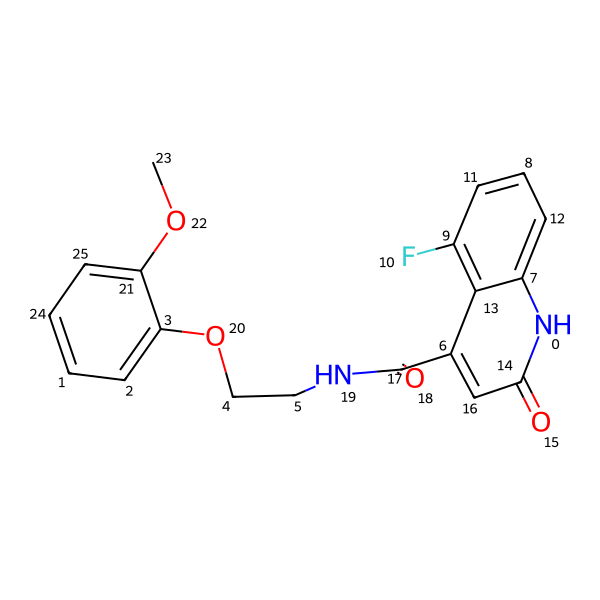

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Configuració per mostrar-ho als quaderns Jupyter
IPythonConsole.ipython_useSVG = True  # Utilitzeu SVG per a imatges de més qualitat
IPythonConsole.drawOptions.addAtomIndices = True  # Mostra els índexs atòmics
IPythonConsole.molSize = 600,600 # Estableix la mida de la imatge

ligand = Chem.MolFromMolFile("lligands/N3R_ideal.sdf")
ligand

[21:57:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


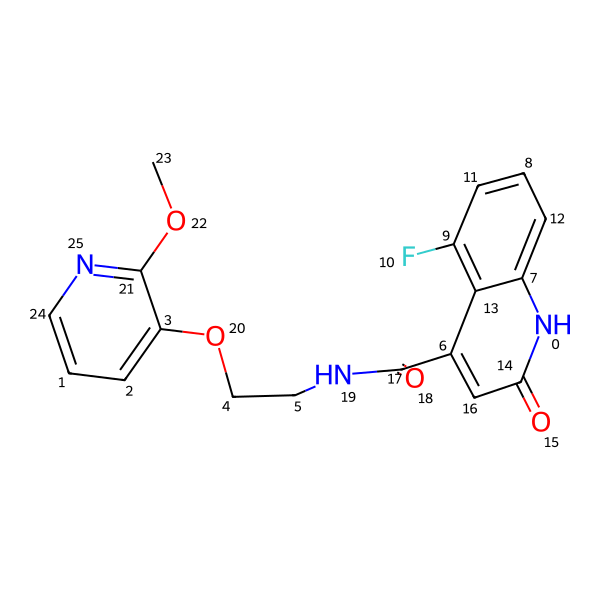

In [10]:
# carrega una còpia duplicada de N3R per manipular
mod_ligand_N = Chem.MolFromMolFile("lligands/N3R_ideal.sdf")

# canvia el carboni 25 per un nitrogen
mod_ligand_N.GetAtomWithIdx(25).SetAtomicNum(7)

mod_ligand_N

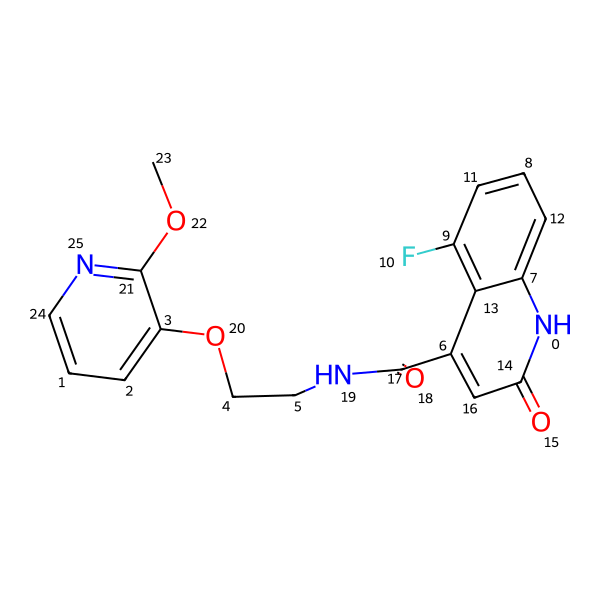

In [11]:
atom = mod_ligand_N.GetAtomWithIdx(25) # Seleccioneu el nostre àtom de nitrogen
atom.SetNumExplicitHs(0) # Estableix el nombre d'hidrògens explícits a 0
# Mira ara la posició 25
mod_ligand_N
#En aquest cas es queda igual ja que sols hem possat un nitrogen i no hem possat hidrogen, ja que no podem posarli un hidrogen mes al nitrogen.

[21:57:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


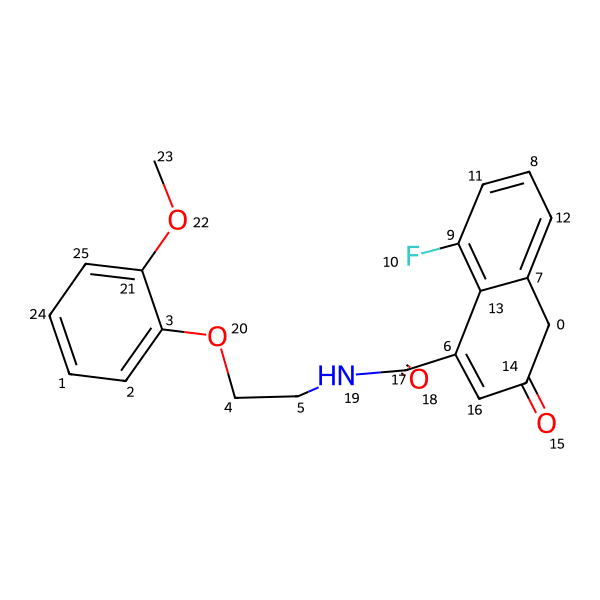

In [12]:
# carrega unaltra còpia duplicada de N3R per manipular
mod_ligand_C = Chem.MolFromMolFile("lligands/N3R_ideal.sdf")

# canvia el nitrogen de l'anell a carboni
mod_ligand_C.GetAtomWithIdx(0).SetAtomicNum(6)

mod_ligand_C

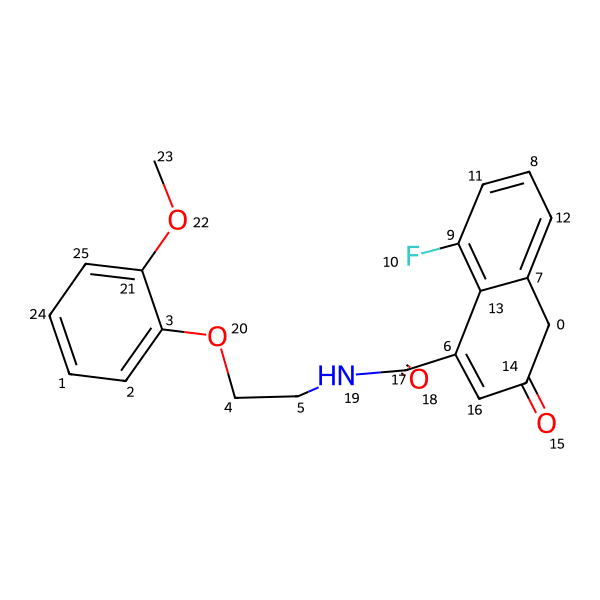

In [13]:
atom = mod_ligand_C.GetAtomWithIdx(0) # Seleccioneu el nostre àtom de carboni
atom.SetNumExplicitHs(2) # Estableix el nombre d'hidrògens explícits a 2
# Mira ara la posició 0
mod_ligand_C

[21:57:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


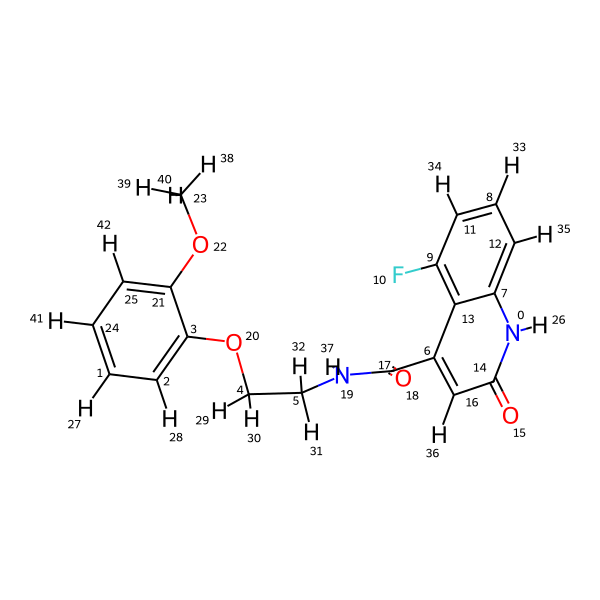

In [14]:
# carrega una altra còpia duplicada de N3R per manipular
mod_ligand_OH = Chem.MolFromMolFile("lligands/N3R_ideal.sdf", removeHs = False)
mod_ligand_OH

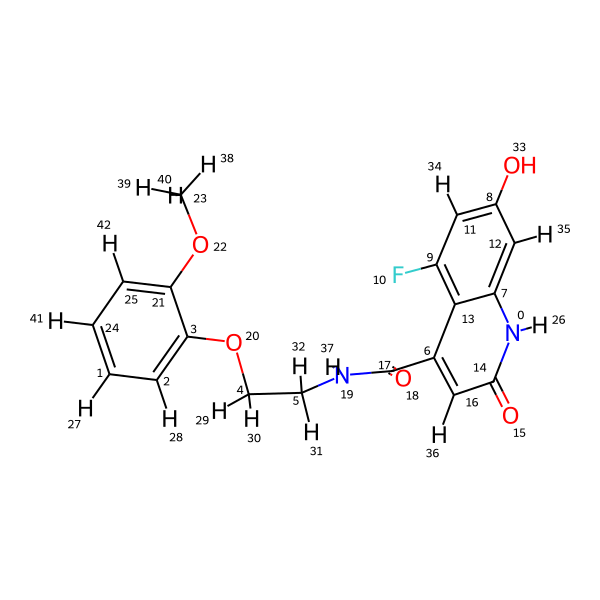

In [15]:
atom = mod_ligand_OH.GetAtomWithIdx(33) # Seleccioneu el nostre àtom de carboni
atom.SetAtomicNum(8)
atom.SetNumExplicitHs(0)

mod_ligand_OH

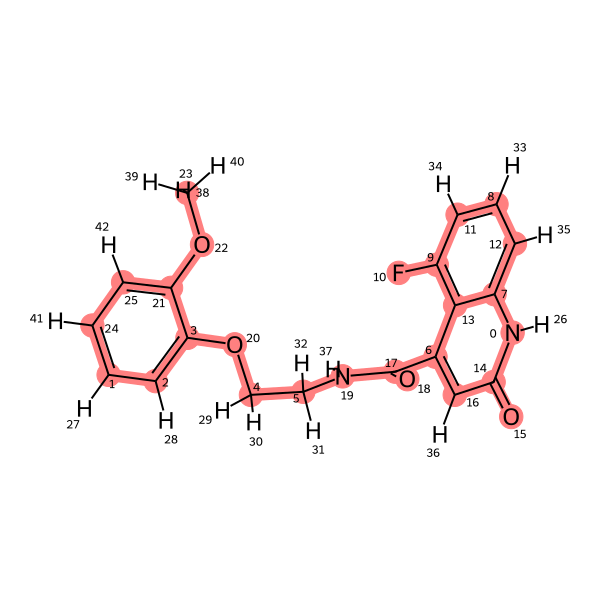

In [16]:
# Optimitza les noves molècules i guarda
from rdkit.Chem import AllChem

Chem.SanitizeMol(ligand)
ligand_NH = Chem.AddHs(ligand)
# Feu una incrustació restringida per mantenir el lligand a la mateixa posició
# això permet afegir els hidrògens en ubicacions raonables, però manté
# els àtoms pesants a la mateixa posició
# Vegeu https://rdkit.org/docs/source/rdkit.Chem.AllChem.html#rdkit.Chem.AllChem.ConstrainedEmbed
constrained_mol = AllChem.ConstrainedEmbed(ligand_NH, ligand, useTethers=True)
constrained_mol

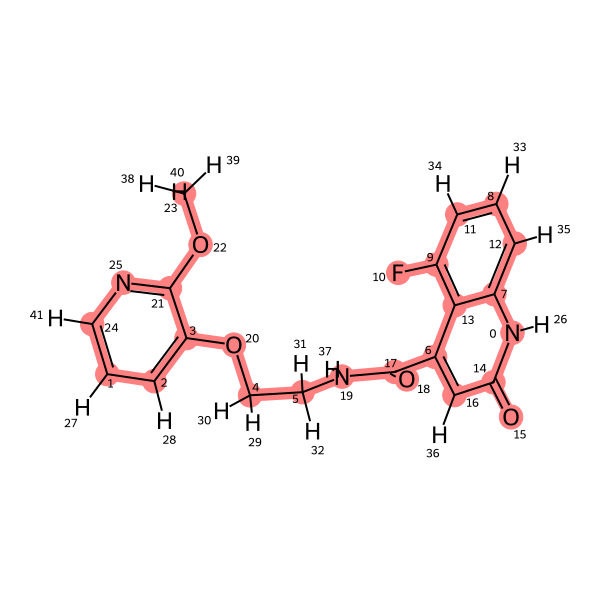

In [17]:
from rdkit.Chem import AllChem

Chem.SanitizeMol(mod_ligand_N)
mod_ligand_NH = Chem.AddHs(mod_ligand_N)

constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_NH, mod_ligand_N, useTethers=True)
constrained_mol

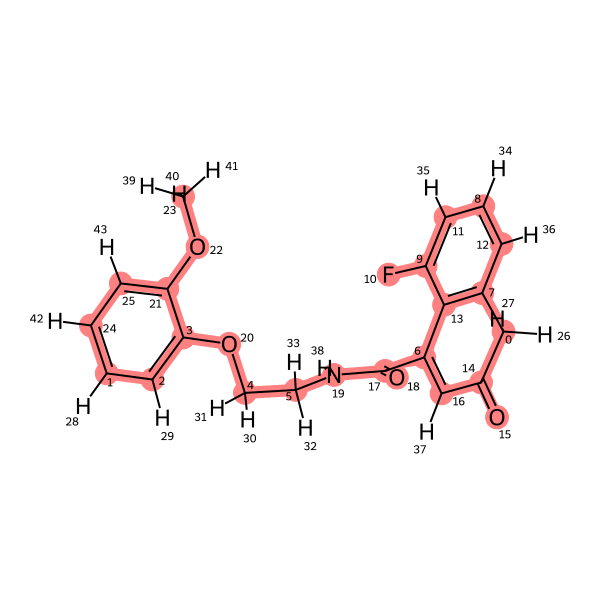

In [18]:
from rdkit.Chem import AllChem

Chem.SanitizeMol(mod_ligand_C)
mod_ligand_CH = Chem.AddHs(mod_ligand_C)


constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_CH, mod_ligand_C, useTethers=True)
constrained_mol

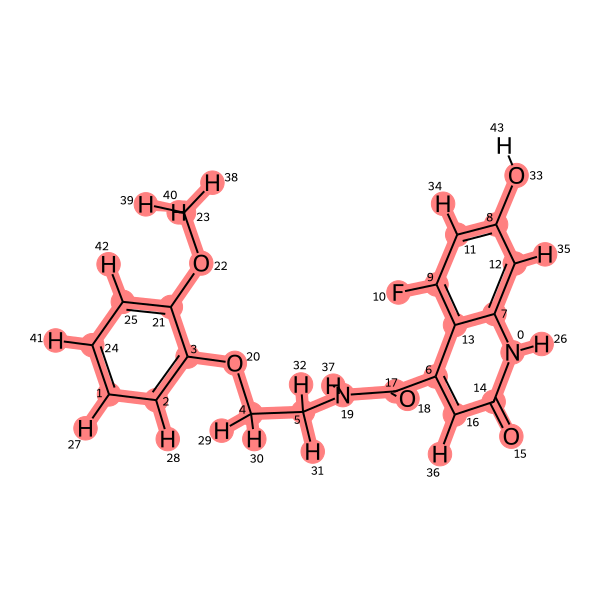

In [19]:
from rdkit.Chem import AllChem

Chem.SanitizeMol(mod_ligand_OH)
mod_ligand_OHH = Chem.AddHs(mod_ligand_OH)


constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_OHH, mod_ligand_OH, useTethers=True)
constrained_mol

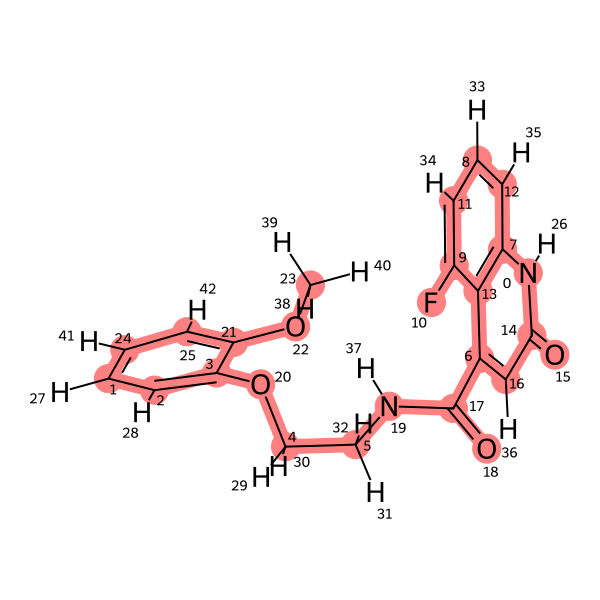

In [20]:
# Realitzar l'optimització de la geometria
opt_N = AllChem.MMFFOptimizeMolecule(ligand_NH)
ligand_NH

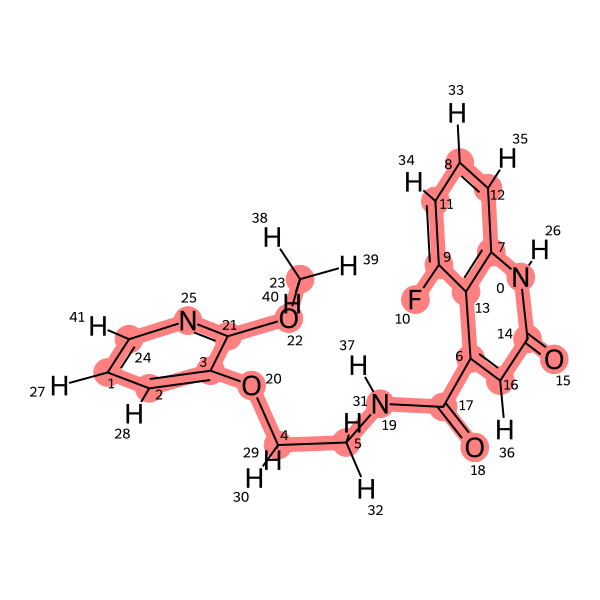

In [21]:
opt_N = AllChem.MMFFOptimizeMolecule(mod_ligand_NH)
mod_ligand_NH

[21:57:10] Molecule does not have explicit Hs. Consider calling AddHs()


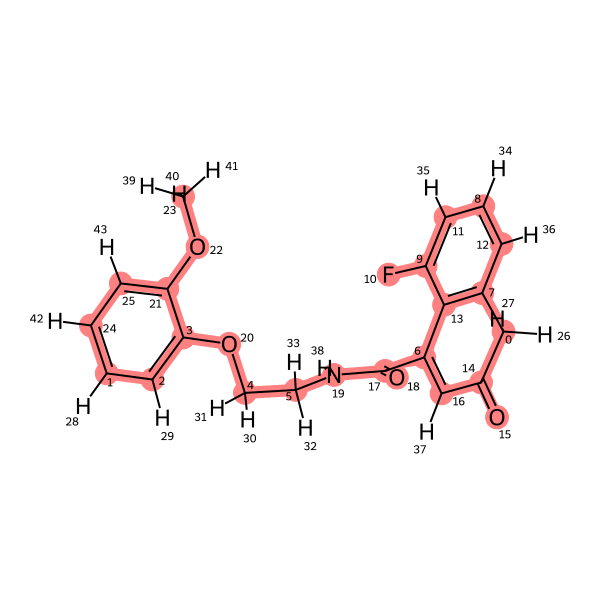

In [22]:
opt_N = AllChem.MMFFOptimizeMolecule(mod_ligand_C)
mod_ligand_CH

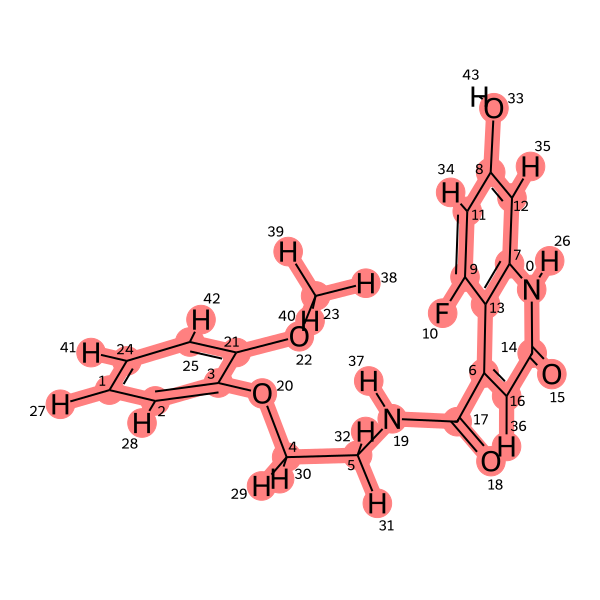

In [23]:
opt_N = AllChem.MMFFOptimizeMolecule(mod_ligand_OHH)
mod_ligand_OHH

In [24]:
# desa en fitxers nous
import os

# crea el directori de lligand modificat
os.makedirs("lligands_per_a_unir", exist_ok=True)

ligand_H = Chem.MolFromMolFile("lligands/N3R_ideal.sdf", removeHs=False)

# desa el fitxer sdf dels lligands modificats: assegura't que tots continguin hidrògens i col·loca'l
# en una carpeta de lligands per acoblar-los.
Chem.MolToMolFile(ligand_H, 'lligands_per_a_unir/N3R.sdf')
Chem.MolToMolFile(ligand_NH, 'lligands_per_a_unir/N3R_optimizat.sdf')
Chem.MolToMolFile(mod_ligand_NH, 'lligands_per_a_unir/N3R_modified_N.sdf')
Chem.MolToMolFile(mod_ligand_CH, 'lligands_per_a_unir/N3R_modified_C.sdf')
Chem.MolToMolFile(mod_ligand_OHH, 'lligands_per_a_unir/N3R_modified_OH.sdf')

[21:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [25]:
#3a part preparació del acoblament


In [26]:
from rcsbsearchapi.search import TextQuery
from rcsbsearchapi import rcsb_attributes as attrs

ECnumber = "3.4.22.69"

q1 = attrs.rcsb_polymer_entity.rcsb_ec_lineage.id == ECnumber
q2 = TextQuery("N3R") ## Empleneu la consulta de text aquí

query = q1 & q2               # combinant les dues consultes en una de sola

results = list(query())
print(results)

['7GE0']


In [27]:
import os # per crear directoris
import requests

# crea un directori per als fitxers pdb
protein_directory = "estructures_de_proteina"

## funció d'ompliment per crear directoris
os.makedirs(protein_directory, exist_ok=True)

pdb_id = results[0]

pdb_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
pdb_request.status_code

200

In [28]:
with open(f"{protein_directory}/{pdb_id}.pdb", "w+") as f:

    f.write(pdb_request.text)

In [29]:
%pip install MDAnalysis

In [30]:
#Per a visualitzar la estructura de la proteina
import MDAnalysis as mda

# Carrega a l'univers MDA
u = mda.Universe(f"{protein_directory}/{pdb_id}.pdb")
u

<Universe with 2655 atoms>

In [31]:
%pip install py3Dmol

In [32]:
import py3Dmol

with open(f"{protein_directory}/{pdb_id}.pdb", "r") as f:
    pdb_data = f.read()

view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, "pdb")
view.addSurface("VMD", {"opacity": 0.8, "color": "white"})
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [33]:
# Select protein atoms
protein = u.select_atoms("protein")
ligand = u.select_atoms("resname N3R")
water = u.select_atoms("resname HOH")

water

<AtomGroup with 257 atoms>

In [34]:
import py3Dmol

# Crea la vista 3D
view = py3Dmol.view(width=800, height=600)

# Carregar l'estructura
view.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read(), 'pdb')  # Reemplaça amb el teu arxiu PDB real

## Representació de la proteïna ##
# Cartoon acolorit per estructura secundària
view.setStyle({'chain': 'A'}, {'cartoon': {'color': 'spectrum'}})

## Representació del lligand N3R ##
view.setStyle({'resn': 'N3R'}, {
    'stick': {
        'colorscheme': 'greenCarbon',
        'radius': 0.2
    },
    'sphere': {
        'scale': 0.3,
        'colorscheme': 'greenCarbon'
    }
})

# Ressaltar àtoms específics del lligand
view.addStyle({'resn': 'N3R', 'elem': 'N'}, {'sphere': {'radius': 0.25, 'color': 'blue'}})
view.addStyle({'resn': 'N3R', 'elem': 'O'}, {'sphere': {'radius': 0.25, 'color': 'red'}})

## Representació de totes les molècules d'aigua ##
view.setStyle({'resn': 'HOH'}, {'sphere': {'radius': 0.3, 'color': 'lightblue'}})

## Superfície al voltant de tota la proteïna ##
view.addSurface(py3Dmol.VDW, {
    'opacity': 0.6,
    'color': 'white'
}, {'chain': 'A'})  # Superfície només per a la cadena A

# Ajustar la vista per mostrar tot el sistema
view.zoomTo()

# Mostrar la vista
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [35]:
# Escriure la proteïna al nou fitxer PDB
protein.write(f"{protein_directory}/protein_{pdb_id}.pdb")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [36]:
!pip install pdb2pqr

In [37]:
!pdb2pqr --pdb-output=estructures_de_proteina/protein_h.pdb --pH=7.4 estructures_de_proteina/protein_7GE0.pdb estructures_de_proteina/protein_7GE0.pqr --whitespace

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: estructures_de_proteina/protein_7GE0.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 304 residues and 2347 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 1 missing atoms in biomolecule.
INFO:Added atom OXT to residue THR A 

In [38]:
# crea un directori per als fitxers pdb
pdbqt_directory = "pdbqt" ## ompliu el nom del directori on escriure els fitxers PDBQT
os.makedirs(pdbqt_directory, exist_ok=True)

u = mda.Universe(f"{protein_directory}/protein_{pdb_id}.pqr")
u.atoms.write(f"{pdbqt_directory}/{pdb_id}.pdbqt")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDBQT.py:305: UserWarning: Supplied AtomGroup was missing the following attributes: altLocs, occupancies, tempfactors. These will be written with default values. 
  warnings.warn(


In [39]:
# Llegeix el fitxer PDBQT acabat d'escriure, reemplaça el text i escriu-lo de nou
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'r') as file:
    file_content = file.read()

file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')

# Escriu el contingut modificat de nou al fitxer
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'w') as file:
    file.write(file_content)

In [40]:
!pip install meeko

In [41]:
# Feu servir meeko per preparar petites molècules: utilitzar meeko ens ajuda a visualitzar-les més tard.
! mk_prepare_ligand.py -i lligands_per_a_unir/N3R.sdf -o pdbqt/N3R.pdbqt
! mk_prepare_ligand.py -i lligands_per_a_unir//N3R_modified_C.sdf -o pdbqt/N3R_modified_C.pdbqt
! mk_prepare_ligand.py -i lligands_per_a_unir//N3R_modified_N.sdf -o pdbqt/N3R_modified_N.pdbqt
! mk_prepare_ligand.py -i lligands_per_a_unir//N3R_modified_OH.sdf -o pdbqt/N3R_modified_OH.pdbqt

Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


In [42]:
# 4a part l'acoblament amb el lligand

In [43]:
# trobar el centre del lligand
import MDAnalysis as mda

original_structure = mda.Universe("estructures_de_proteina/7GE0.pdb")
ligand_mda = original_structure.select_atoms("resname N3R")

# Obtingueu el centre del lligand com a "pocket center"
pocket_center = ligand_mda.center_of_geometry() ## Fill in code for measuring the center of geometry of the ligand.
print(pocket_center)

[ 8.10157695 -0.03611539 20.98534621]


In [44]:
# calcula les coordenades mínima i màxima del lligand
# pren la caixa del lligand com la diferència entre el màxim i el mínim en cada direcció.
ligand_box = ligand_mda.positions.max(axis=0) - ligand_mda.positions.min(axis=0) + 5 ## Ompliu la resta d'aquesta expressió.
ligand_box

array([15.913   , 10.191999, 11.723999], dtype=float32)

In [45]:
pocket_center = pocket_center.tolist()
ligand_box = ligand_box.tolist() ## converteix ligand_box a llista

In [46]:
# creeu un directori per emmagatzemar els nostres resultats
import os

pdb_id = "7GE0"
ligand = "N3R"

## Crea un directori anomenat "resultats_de_acoplament"
os.makedirs("resultats_de_acoplament", exist_ok=True)

In [47]:
%pip install vina

In [48]:
from vina import Vina
v = Vina(sf_name="vina")

In [49]:
v.set_receptor(f"pdbqt/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt/{ligand}.pdbqt") ## Ompliu el nom del lligand
v.compute_vina_maps(center=pocket_center, box_size=ligand_box) ## Empleneu el centre del lligand i la mida de la caixa calculats anteriorment.

In [50]:
v.dock(exhaustiveness=32, n_poses=5)

In [51]:
v.write_poses(f"resultats_de_acoplament/{ligand}.pdbqt", n_poses=5, overwrite=True)

In [52]:
## Empleneu el codi per veure les energies calculades per a les postures.
v.energies()

array([[-7.12 , -9.618, -0.685,  2.497, -0.685],
       [-7.095, -9.391, -0.879,  2.489, -0.685],
       [-7.052, -9.045, -1.166,  2.474, -0.685],
       [-6.988, -8.4  , -1.725,  2.451, -0.685],
       [-6.911, -9.143, -0.877,  2.424, -0.685]])

In [53]:
import pandas as pd


# Aquestes són les columnes per als tipus d'energies segons la documentació d'AutoDock Vina.
column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns = column_names) ## Empleneu els arguments del dataframe per crear un dataframe amb energies.
df.head()

total  inter  intra  torsions  intra best pose
0 -7.120 -9.618 -0.685     2.497           -0.685
1 -7.095 -9.391 -0.879     2.489           -0.685
2 -7.052 -9.045 -1.166     2.474           -0.685
3 -6.988 -8.400 -1.725     2.451           -0.685
4 -6.911 -9.143 -0.877     2.424           -0.685

In [54]:
# Desa les energies calculades de l'acoblament a un fitxer CSV
df.to_csv("resultats_de_acoplament/N3R_energies.csv", index=False)

In [55]:
! mk_export.py resultats_de_acoplament/N3R.pdbqt -s resultats_de_acoplament//N3R.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024.

In [56]:
%pip install prolif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 36.2 MB/s eta 0:00:00


In [57]:
import prolif as plf
import MDAnalysis as mda

pdb_id = "7GE0"

protein = mda.Universe(f"estructures_de_proteina/protein_h.pdb")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


In [58]:
protein_plf = plf.Molecule.from_mda(protein)
poses_plf = plf.sdf_supplier("resultats_de_acoplament/N3R.sdf")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/converters/RDKit.py:497: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


In [59]:
fp = plf.Fingerprint(count=True)

In [60]:
fp.run_from_iterable(poses_plf, protein_plf)

  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7a33e0f89cd0>

In [61]:
pose_index=1

In [62]:
fp.plot_lignetwork(poses_plf[pose_index])

In [63]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [64]:
#Per a N3R modificat N
pdb_id = "7GE0"
ligandH = "N3R_modified_N"


os.makedirs("resultats_de_acoplament", exist_ok=True)
v.set_receptor(f"pdbqt/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt/{ligandH}.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)
v.dock(exhaustiveness=32, n_poses=5)
v.write_poses(f"resultats_de_acoplament/{ligandH}.pdbqt", n_poses=5, overwrite=True)

v.energies()

column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns = column_names)
df.head()


total  inter  intra  torsions  intra best pose
0 -7.002 -9.458 -1.033     2.456           -1.033
1 -6.965 -9.230 -1.211     2.443           -1.033
2 -6.952 -9.391 -1.033     2.439           -1.033
3 -6.849 -9.224 -1.060     2.402           -1.033
4 -6.713 -8.725 -1.375     2.355           -1.033

In [65]:
df.to_csv("resultats_de_acoplament/N3RH_energies.csv", index=False)

In [66]:
! mk_export.py resultats_de_acoplament/N3R_modified_N.pdbqt -s resultats_de_acoplament//N3R_modified_N.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024

In [67]:
posesH_plf = plf.sdf_supplier("resultats_de_acoplament/N3R_modified_N.sdf")

In [68]:
fp.run_from_iterable(posesH_plf, protein_plf)
pose_index=1
fp.plot_lignetwork(posesH_plf[pose_index])

  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
view = fp.plot_3d(
    posesH_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [70]:
#Per a N3R modificat C
pdb_id = "7GE0"
ligandC = "N3R_modified_C"


os.makedirs("resultats_de_acoplament", exist_ok=True)
v.set_receptor(f"pdbqt/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt/{ligandC}.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)
v.dock(exhaustiveness=32, n_poses=5)
v.write_poses(f"resultats_de_acoplament/{ligandC}.pdbqt", n_poses=5, overwrite=True)

v.energies()

column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns = column_names)
df.head()


total  inter  intra  torsions  intra best pose
0 -6.842 -9.242 -1.208     2.400           -1.208
1 -6.776 -9.436 -0.925     2.377           -1.208
2 -6.646 -8.982 -1.203     2.331           -1.208
3 -6.614 -8.507 -1.635     2.320           -1.208
4 -6.550 -9.046 -1.009     2.297           -1.208

In [71]:
df.to_csv("resultats_de_acoplament/N3RC_energies.csv", index=False)

In [72]:
! mk_export.py resultats_de_acoplament/N3R_modified_C.pdbqt -s resultats_de_acoplament//N3R_modified_C.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024

In [73]:
posesC_plf = plf.sdf_supplier("resultats_de_acoplament/N3R_modified_C.sdf")

In [74]:
fp.run_from_iterable(posesC_plf, protein_plf)
pose_index=1
fp.plot_lignetwork(posesC_plf[pose_index])

  0%|          | 0/5 [00:00<?, ?it/s]

In [75]:
view = fp.plot_3d(
    posesC_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [76]:
#Per a N3R modificat OH
pdb_id = "7GE0"
ligandOH = "N3R_modified_OH"


os.makedirs("resultats_de_acoplament", exist_ok=True)
v.set_receptor(f"pdbqt/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt/{ligandOH}.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)
v.dock(exhaustiveness=32, n_poses=5)
v.write_poses(f"resultats_de_acoplament/{ligandOH}.pdbqt", n_poses=5, overwrite=True)

v.energies()

column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns = column_names)
df.head()

total  inter  intra  torsions  intra best pose
0 -7.160 -9.881 -0.958     2.721           -0.958
1 -7.104 -9.553 -1.208     2.700           -0.958
2 -7.061 -8.918 -1.784     2.683           -0.958
3 -6.933 -9.139 -1.386     2.634           -0.958
4 -6.835 -9.188 -1.202     2.597           -0.958

In [77]:
df.to_csv("resultats_de_acoplament/N3ROH_energies.csv", index=False)

In [78]:
! mk_export.py resultats_de_acoplament/N3R_modified_OH.pdbqt -s resultats_de_acoplament//N3R_modified_OH.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024

In [79]:
posesOH_plf = plf.sdf_supplier("resultats_de_acoplament/N3R_modified_OH.sdf")

In [80]:
fp.run_from_iterable(posesOH_plf, protein_plf)
pose_index=1
fp.plot_lignetwork(posesOH_plf[pose_index])

  0%|          | 0/5 [00:00<?, ?it/s]

In [81]:
view = fp.plot_3d(
    posesOH_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.